In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Dict

In [2]:
DATA_DIR = Path(os.path.abspath('') + '/results').resolve()
assert DATA_DIR.is_dir()

def read_data(data_file: Path) -> List[Dict[str, List[str]]]:
    assert data_file.is_file()
    with open(data_file, 'r') as f:
        return json.load(f)

In [3]:
f = Path('{}/results_regexlib_exploit_strings.json'.format(DATA_DIR))
regexlib_data = read_data(f)

In [4]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, ['JDK{}'.format(k) for k in data.keys()])

In [5]:
x_data = {}

for entry in regexlib_data:
    for java_version, times in entry.items(): 
        if java_version not in x_data.keys(): x_data[java_version] = []
        tmp = map(lambda s: int(s), filter(lambda t: t.isdigit(), times))
        print('JDK{} max matching time: {} ms'.format(java_version, max(tmp)))
        data = []
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 0 and int(s) <= 5, times))))
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 5 and int(s) <= 10, times))))
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 10 and int(s) <= 20, times))))
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 20 and int(s) <= 50, times))))
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 50 and int(s) <= 100, times))))
        data.append(len(list(filter(lambda s: s.isdigit() and int(s) > 100, times))))
        data.append(len(list(filter(lambda s: s == 'timeout', times))))
        x_data[java_version] = np.array(data)

JDK11-modified max matching time: 448 ms
JDK11 max matching time: 5550 ms
JDK9 max matching time: 4131 ms
JDK8 max matching time: 7 ms


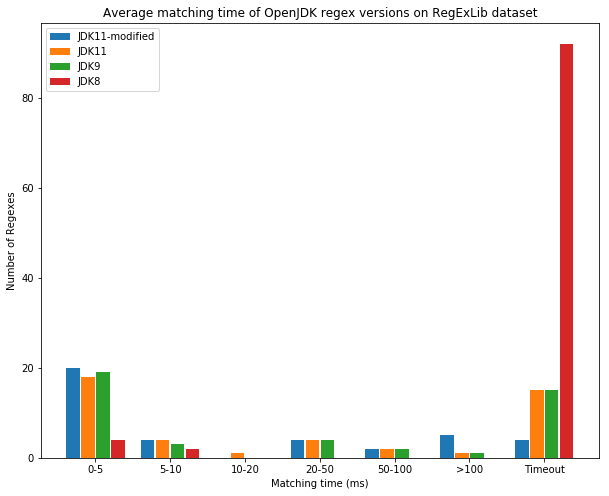

In [6]:
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '>100', 'Timeout']

fig, ax = plt.subplots(figsize=(10, 8))

bar_plot(ax, x_data, total_width=.8, single_width=.9)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Matching time (ms)')
ax.set_ylabel('Number of Regexes')
ax.set_title('Average matching time of OpenJDK regex versions on RegExLib dataset')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)

plt.show()

### Filter 0ms matching times

For the box plots we filter out 0ms matching times because it skews the data. We plot the y-axes at a linear and log scale.

In [7]:
data, xlabels = [], []
for entry in regexlib_data:
    for java_version, times in entry.items():
        xlabels.append('JDK{}'.format(java_version))
        times = list(filter(lambda t: t != '0', times))
        data.append(list(map(lambda t: 5000 if t == 'timeout' else int(t), times)))

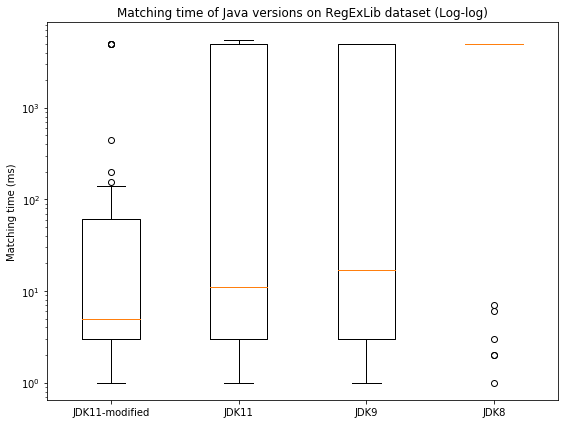

In [8]:
fig, axes = plt.subplots(figsize=(8,6))

def plot(fig, ax, title: str, yscale='linear'):
    # Creating plot 
    ax.boxplot(data) 
    
    ax.set_xticks(np.arange(1, len(xlabels)+1))
    ax.set_xticklabels(xlabels)

    plt.ylabel('Matching time (ms)')
    plt.yscale(yscale)
    plt.title(title)
    
    fig.tight_layout()
    plt.show() 
    
plot(fig, axes, 'Matching time of Java versions on RegExLib dataset (Log-log)', 'log')

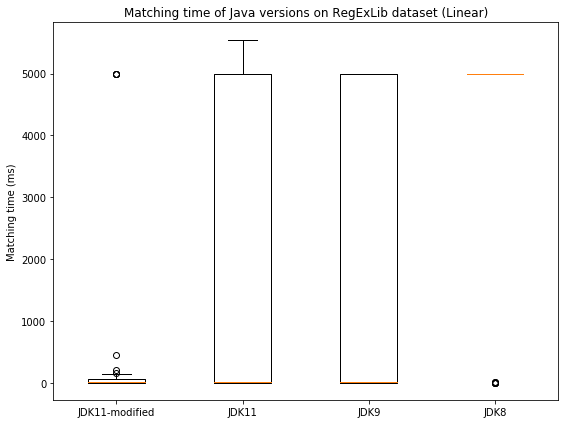

In [9]:
fig, axes = plt.subplots(figsize=(8,6))
plot(fig, axes, 'Matching time of Java versions on RegExLib dataset (Linear)', 'linear')